In [1]:
import numpy as np
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [2]:
log_params = {"A": 11.813539214813655, "mu_m": 0.02001919118343915, "lambda": -73.01216063634942}
incubation_time = 5.5 * 60 * 60 
def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

In [3]:
edt = np.load('../../2023_12_06_tweez/Pos 14/results/edt.npy')
nt,nx,ny = edt.shape
print(edt.shape)

(216, 1024, 1024)


In [4]:
from skimage.io import imread

im = imread('../../2023_12_06_tweez/Pos 14/10x_1.0x_MC4100_pLPT20&41_TiTweez_1_MMStack_Pos14.ome.2.tif')
#im = imread('../../2023_12_04_tweez/Pos 10/10x_1.0x_MC4100_pLPT107&41_TiTweez_1_MMStack_Pos10.ome.tif')
#im = im[:,:,:,:]
#im = im.transpose([0,2,3,1])
im = im[:,:,:,2:]
print(im.shape)

(216, 1024, 1024, 2)


In [5]:
edt = np.pad(edt, ((0,0),(256,256),(256,256)))
im = np.pad(im, ((0,0),(256,256),(256,256),(0,0)))
nt,nx,ny = edt.shape

In [6]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,2))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]
    crop_im[t,:,:] = tim[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad,:]

400 392
(216, 912, 904)


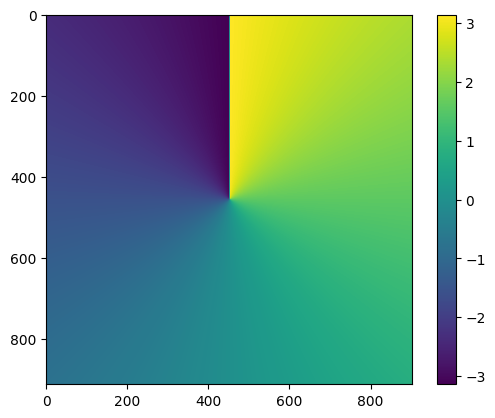

In [11]:
nt,nx,ny = crop_edt.shape
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
x = x - nx/2
y = y - ny/2
angle = np.arctan2(y, x)
plt.imshow(angle)
plt.colorbar()

In [43]:
import numpy as np
from scipy.stats import skew, kurtosis

def bimodality_coefficient(x):
    n = len(x)
    if n < 3:
        return np.nan
    k = kurtosis(x)
    g = skew(x)
    return (g**2 + 1) / (k + 3 * ((n - 1)**2) / ((n - 2) * (n - 3)))

rs = np.arange(int(np.nanmax(crop_edt)))
nt = crop_edt.shape[0]
rcorr = np.zeros((nt, len(rs))) + np.nan
bimodality = np.zeros((nt, len(rs))) + np.nan  # Array to store bimodality coefficient

t0,t1 = 50,216
mask = (crop_edt[t0:t1,:,:]>0) * 1
tmask = mask.mean(axis=0)
tmask = gaussian_filter(tmask, 8)>0.5
tedt = distance_transform_edt(tmask)
for t in range(t0,t1):
    print(f'Computing frame {t+1}/{nt}')
    for ir in range(len(rs)):
        #tedt = crop_edt[t, :, :]
        tim0 = crop_im[t, :, :, 0]
        tim1 = crop_im[t, :, :, 1]
        x = tim0[np.abs(tedt - rs[ir]) < 8]
        y = tim1[np.abs(tedt - rs[ir]) < 8]
        if len(x) > 10:
            C = np.corrcoef(x, y)
            rcorr[t, ir] = C[0, 1]
            # Calculate and store the bimodality coefficient for x and y
            #bimodality[t, ir] = bimodality_coefficient(y)

# Now rcorr contains the correlation coefficients and bimodality contains the bimodality coefficients


Computing frame 51/216
Computing frame 52/216
Computing frame 53/216
Computing frame 54/216
Computing frame 55/216
Computing frame 56/216
Computing frame 57/216
Computing frame 58/216
Computing frame 59/216
Computing frame 60/216
Computing frame 61/216
Computing frame 62/216
Computing frame 63/216
Computing frame 64/216
Computing frame 65/216
Computing frame 66/216
Computing frame 67/216
Computing frame 68/216
Computing frame 69/216
Computing frame 70/216
Computing frame 71/216
Computing frame 72/216
Computing frame 73/216
Computing frame 74/216
Computing frame 75/216
Computing frame 76/216
Computing frame 77/216
Computing frame 78/216
Computing frame 79/216
Computing frame 80/216
Computing frame 81/216
Computing frame 82/216
Computing frame 83/216
Computing frame 84/216
Computing frame 85/216
Computing frame 86/216
Computing frame 87/216
Computing frame 88/216
Computing frame 89/216
Computing frame 90/216
Computing frame 91/216
Computing frame 92/216
Computing frame 93/216
Computing f

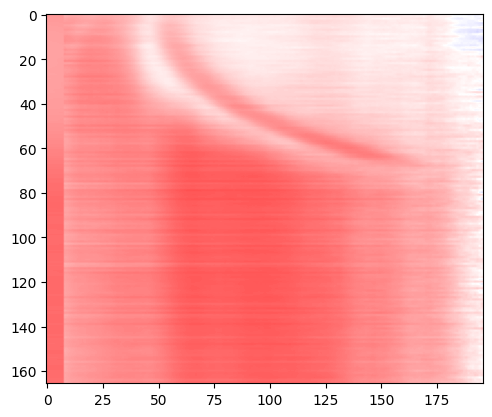

In [44]:
plt.imshow(rcorr[50:216,:] , cmap='bwr', vmin=-1, vmax=1)
#plt.colorbar()

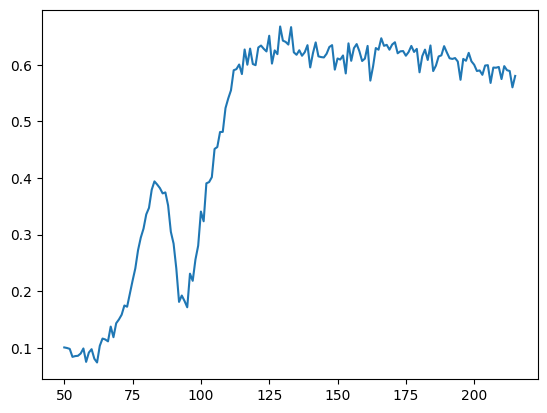

In [46]:
plt.plot(rcorr[:,75])

33588
171 72


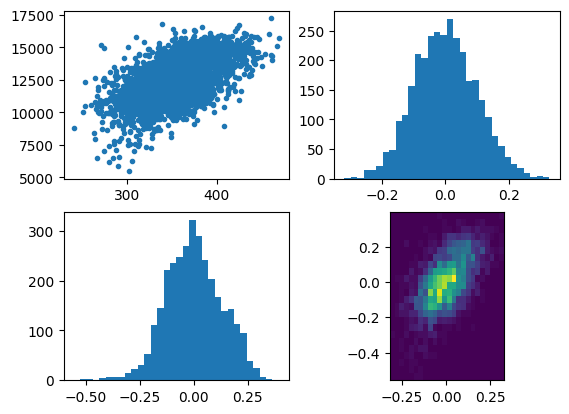

In [42]:
idx = np.where(rcorr.ravel()>0.5)[0] # 
idx = np.random.choice(idx, 1)[0]
print(idx)
it,r = np.unravel_index(idx, rcorr.shape)
print(it,r)

t0,t1 = 50,216
mask = (crop_edt[t0:t1,:,:]>0) * 1
tmask = mask.mean(axis=0)
tmask = gaussian_filter(tmask, 8)>0.5
tedt = distance_transform_edt(tmask)

tim0 = crop_im[it,:,:,0]
tim1 = crop_im[it,:,:,1]
x = tim0[np.abs(tedt-r)<2]
y = tim1[np.abs(tedt-r)<2]

plt.subplot(2, 2, 1)
plt.plot(x, y, '.')
plt.subplot(2, 2, 2)
_ = plt.hist((x-x.mean()) / x.mean(), bins=32)
plt.subplot(2, 2, 3)
_ = plt.hist((y-y.mean()) / y.mean(), bins=32)
plt.subplot(2, 2, 4)
h, xedges, yedges, him = plt.hist2d((x-x.mean()) / x.mean(), (y-y.mean()) / y.mean(), bins=24)
plt.imshow(h, aspect='equal')

In [20]:
from scipy.ndimage import distance_transform_edt, gaussian_filter

def get_traces(r, t0, t1):
    ntt = t1 - t0
    mask = (crop_edt[t0:t1,:,:]>0) * 1
    tmask = mask.mean(axis=0)
    tmask = gaussian_filter(tmask, 8)>0.5
    tedt = distance_transform_edt(tmask)
    tedt = tedt.ravel()
    idx = np.where(np.abs(tedt-r)<0.5)[0]
    npix = len(idx)
    xx = np.arange(t0, t1)
    yy = np.zeros((ntt,npix))
    zz = np.zeros((ntt,npix))
    ang = np.zeros((ntt,npix))
    for t in range(t0, t1):
        tim0 = crop_im[t,:,:,0].ravel()
        tim1 = crop_im[t,:,:,1].ravel()
        y = tim0[idx]
        z = tim1[idx]
        yy[t-t0,:] = (y - np.nanmean(y)) / np.nanmean(y)
        zz[t-t0,:] = (z - np.nanmean(z)) / np.nanmean(z)
        ang[t-t0,:] = angle.ravel()[idx]
    return xx,yy,zz,ang

[ 30.          64.24428901  98.48857802 132.73286703 166.97715604]


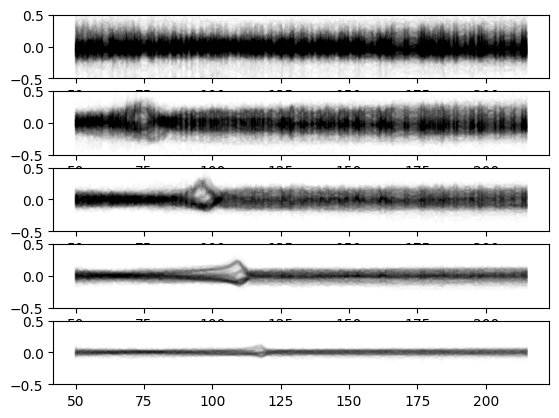

In [21]:
from scipy.stats import gaussian_kde

t0,t1 = 50,216
ntt = t1 - t0
rs = np.linspace(30, crop_edt.max()-30, 5) # [30,70,110,150,190] # np.nanmax(crop_edt)
print(rs)
for r in range(len(rs)):
    xx,yy,zz,ang = get_traces(rs[r], t0, t1)
    plt.subplot(len(rs),1,r+1)
    _ = plt.plot(xx, zz[:,:], 'k', alpha=0.01)
    plt.ylim([-0.5,0.5])

50 216


NameError: name 'rcorr' is not defined

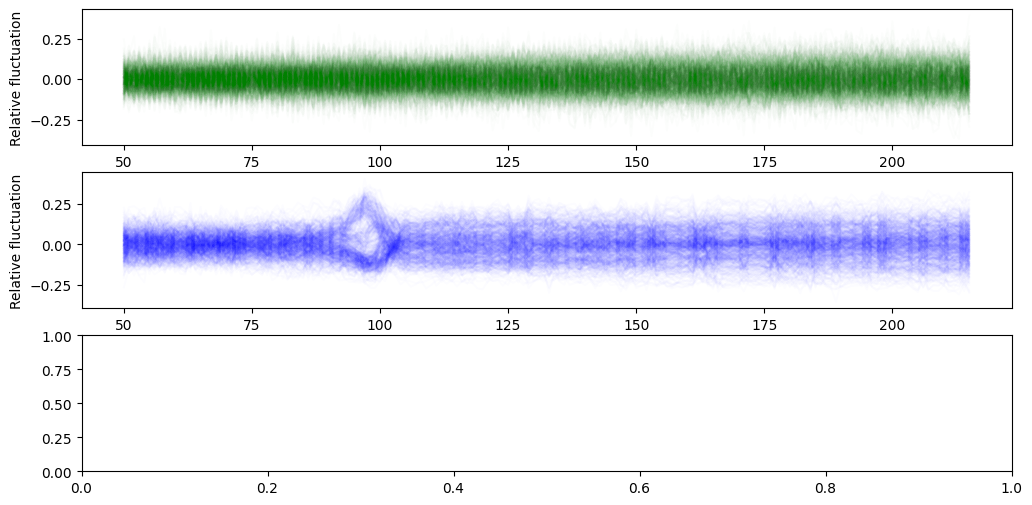

In [22]:
xx,yy,zz,ang = get_traces(100, t0, t1)

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
_ = plt.plot(xx, yy[:,:], 'g', alpha=0.01)
plt.ylabel('Relative fluctuation')
plt.subplot(3,1,2)
_ = plt.plot(xx, zz[:,:], 'b', alpha=0.01)
plt.xlabel('Time (frames)')
plt.ylabel('Relative fluctuation')
plt.subplot(3,1,3)
print(t0, t1)
print(rcorr.shape)
_ = plt.plot(xx, rcorr[t0:t1,150])
plt.ylabel('Correlation')
plt.xlabel('Time (frames)')


(166, 948)


(-0.5, 0.5)

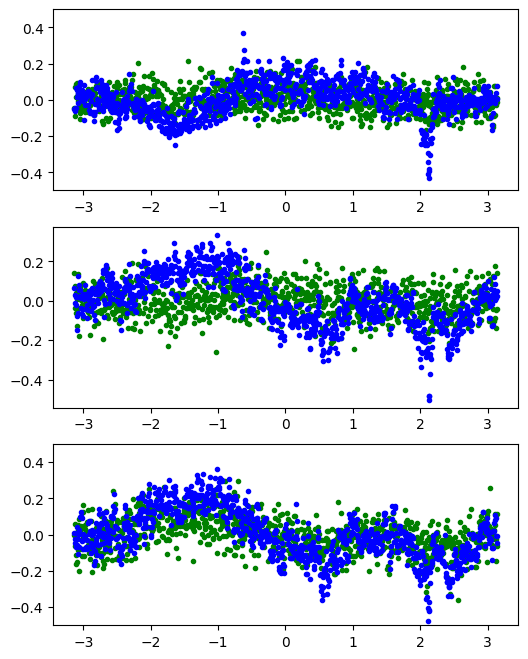

In [23]:
from scipy.stats import gaussian_kde

t0,t1 = 50,216
ntt = t1 - t0
xx,yy,zz,ang = get_traces(64, t0, t1)
print(ang.shape)
plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
_ = plt.plot(ang[50-t0,:], yy[50-t0,:], 'g.') # , alpha=0.01)
_ = plt.plot(ang[50-t0,:], zz[50-t0,:], 'b.') # , alpha=0.01)
plt.ylim([-0.5,0.5])
plt.subplot(3,1,2)
_ = plt.plot(ang[90-t0,:], yy[90-t0,:], 'g.') # , alpha=0.01)
_ = plt.plot(ang[90-t0,:], zz[90-t0,:], 'b.') # , alpha=0.01)
plt.subplot(3,1,3)
_ = plt.plot(ang[130-t0,:], yy[130-t0,:], 'g.') # , alpha=0.01)
_ = plt.plot(ang[130-t0,:], zz[130-t0,:], 'b.') # , alpha=0.01)
plt.ylim([-0.5,0.5])

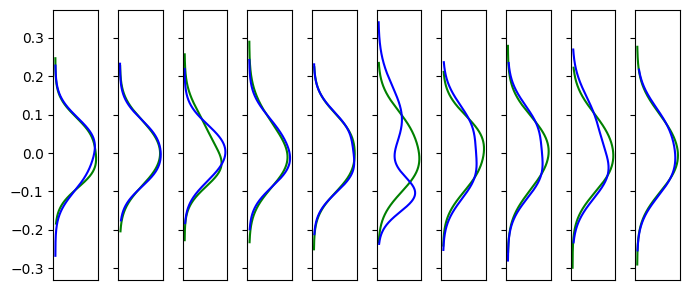

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

def plot_gmm(yyy, ax, orientation='vertical', color='r'):
    # Plot histogram
    #ax.hist(yyy, bins=24, density=True, alpha=0.3, color=color, orientation=orientation)

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust n_components as needed
    gmm.fit(yyy.reshape(-1, 1))

    # Plot the GMM components
    x = np.linspace(min(yyy), max(yyy), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    if orientation=='vertical':
        ax.plot(x, pdf, color=color, label='Total PDF')
        #ax.plot(x, pdf_individual, '--', label='Individual Gaussians')
    else:
        ax.plot(pdf, x, color=color, label='Total PDF')
        #ax.plot(pdf_individual, x, '--', label='Individual Gaussians')
    #ax.legend()

t0,t1 = 50,216
xx,yy,zz,ang = get_traces(100, t0, t1)
ts = np.arange(50, 150, 10) #
fig,axs = plt.subplots(1, len(ts), sharey=True, figsize=(7,3))
for t in range(len(ts)):    
    #axs[t].hist(yy[xx==ts[t]], bins=32)
    plot_gmm(yy[xx==ts[t],:].transpose(), axs[t], orientation='horizontal', color='g')
    plot_gmm(zz[xx==ts[t],:].transpose(), axs[t], orientation='horizontal', color='b')
    #axs[t].set_title(f't = {ts[t]}')
    axs[t].set_xticks([])
plt.tight_layout()

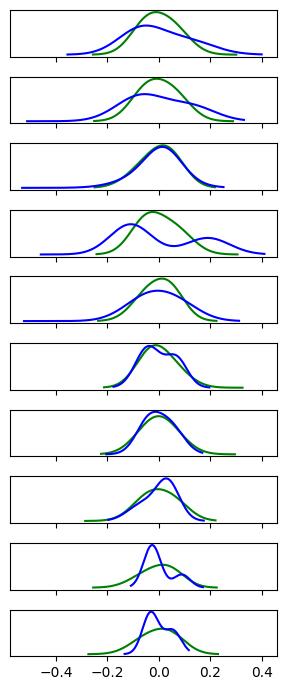

In [25]:
rs = np.linspace(50, 150, 10) #[45,50,55] # np.arange(100,200,20)
fig,axs = plt.subplots(len(rs), 1, sharex=True, figsize=(3,7))
for ri in range(len(rs)):  
    xx,yy,zz,ang = get_traces(rs[ri], t0, t1)  
    #axs[ri].hist(zz[xx==90,:].transpose(), bins=24, density=True, alpha=0.3, color='g')
    #axs[ri].hist(ww[xx==90,:].transpose(), bins=24, density=True, alpha=0.3, color='b')
    plot_gmm(yy[xx==90,:].transpose(), axs[ri], color='g')
    plot_gmm(zz[xx==90,:].transpose(), axs[ri], color='b')
    #axs[ri].set_title(f'r = {rs[ri]}')
    axs[ri].set_yticks([])
plt.tight_layout()

In [8]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 10
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt

In [9]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

edt_blocks = split_edt_into_blocks(crop_edt, 16)
im_blocks = split_image_into_blocks(crop_im, 16)
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)


(216, 57, 56, 2)


In [10]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,57,57))
#crop_im_low = np.zeros((nt,57,57,2))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(249, 57, 56)


In [59]:
nt,nbx,nby,nxx,nyy,nc = im_blocks.shape

cov = np.zeros((nt,nbx,nby,2,2)) + np.nan
corr = np.zeros((nt,nbx,nby)) + np.nan
for bx in range(nbx):
    for by in range(nby):
        for t in range(nt):
            if crop_edt[t + int(offset), bx, by]>0:
                x = im_blocks[t,bx,by,:,:,0].ravel()
                y = im_blocks[t,bx,by,:,:,1].ravel()
                C = np.cov(x, y)
                cov[t,bx,by,:,:] = C
                corr[t,bx,by] = np.corrcoef(x, y)[0,1]

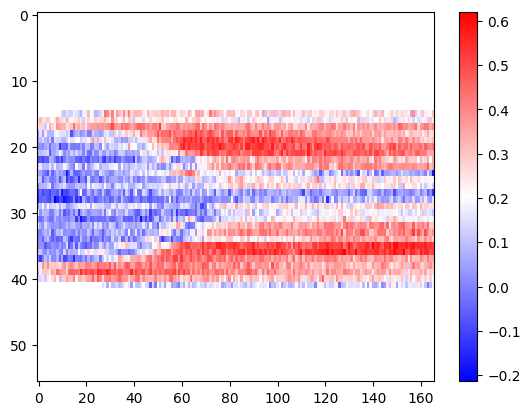

In [60]:
plt.imshow(corr[50:216,int(nbx//2),:].transpose(), aspect='auto', cmap='bwr', interpolation='none')
plt.colorbar()

53053
16 35 21
[[ 1.         -0.27153916]
 [-0.27153916  1.        ]]
nan
[[1.         0.11167414]
 [0.11167414 1.        ]]


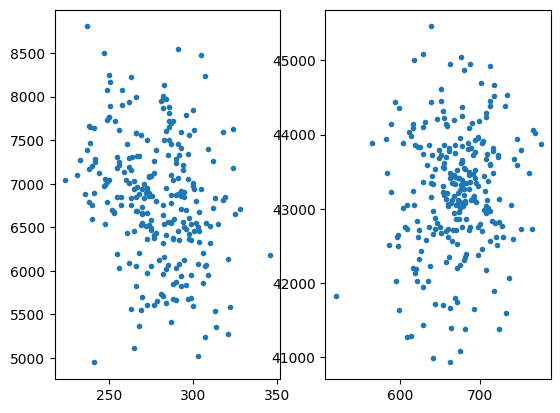

In [61]:
idx = np.nanargmin(corr[50:,:,:])
print(idx)
it,ix,iy = np.unravel_index(idx, corr.shape)
print(it,ix,iy)
plt.subplot(1, 2, 1)

x = im_blocks[it + 50,ix,iy,:,:,0].ravel()
y = im_blocks[it + 50,ix,iy,:,:,1].ravel()
plt.plot(x, y, '.')
print(np.corrcoef(x,y))
print(corr.ravel()[idx])

plt.subplot(1, 2, 2)
x = im_blocks[idx0 + 90,int(nx//2),int(ny//2),:,:,0].ravel()
y = im_blocks[idx0 + 90,int(nx//2),int(ny//2),:,:,1].ravel()
plt.plot(x, y, '.')
print(np.corrcoef(x,y))

#plt.hist2d(x, y, bins=16)

In [11]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='nearest')
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    du[tmask] -= gamma * u[tmask] * gr
    return du.ravel()

In [12]:
def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def nhill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx) * (1 + K**n)

def step(x, K):
    return (x > K) * 1

p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp):
    #G -| R -| B
    p = p.reshape((nx,ny,4))
    dpdt = np.zeros_like(p)
    # LacI
    #dpdt[:,:,0] = step(uu, KK0) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = nhill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    dpdt[:,:,0] = hill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    # TetR
    #dpdt[:,:,1] = step(uu, KK1) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = nhill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    dpdt[:,:,1] = hill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    # cI
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,2] = hill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    # mCFP
    #dpdt[:,:,3] = step(uu, KK3) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = nhill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    dpdt[:,:,3] = hill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
    for c in range(4):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()

In [44]:
from scipy.integrate import odeint


def solve_gene_expression(rep00, rep01, rep02, u, alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,4))
    p[0,:,:,0] = rep00
    p[0,:,:,1] = rep01
    p[0,:,:,2] = rep02
    p[0,:,:,3] = rep01
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        dp = dpdt(p[ti,:,:,:], t, tmask>0, u[ti,:,:], alpha0, alpha1, alpha2, alpha3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,4)
        mask[ti+1,:,:] = tmask
    
    #p[:-1,:,:,0] = hill(u, KK0, nn) * p[:-1,:,:,0]
    #p[:-1,:,:,1] = hill(u, KK1, nn) * p[:-1,:,:,1]
    #p[:-1,:,:,2] = hill(u, KK2, nn) * p[:-1,:,:,2]
    #p[:-1,:,:,3] = hill(u, KK2, nn) * p[:-1,:,:,3]
    pmask = np.zeros_like(p) + np.nan
    for c in range(4):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>0, 0, kappa, gamma, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask

In [95]:
rep00,rep01,rep02 = 5,1,1
alpha0,alpha1,alpha2,alpha3 = 1e3,1e3,1e3,1e3
beta0,beta1,beta2 = 0,0,0
K0,K1,K2 = 1e2,1e2,1e2
km0,km1,km2 = 1e-4,1e-4,1e-4
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 2
nn = 2
kappa = 1e-13
gamma = 1
gamma_fp = np.log(2) / (6 * 60 * 60)
gamma_repr = np.log(2) / (1 * 60 * 60)
dx = 16e-6
dt = 10
t0 = 0

ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

14940
10080


Text(0, 0.5, 'Position (pixels)')

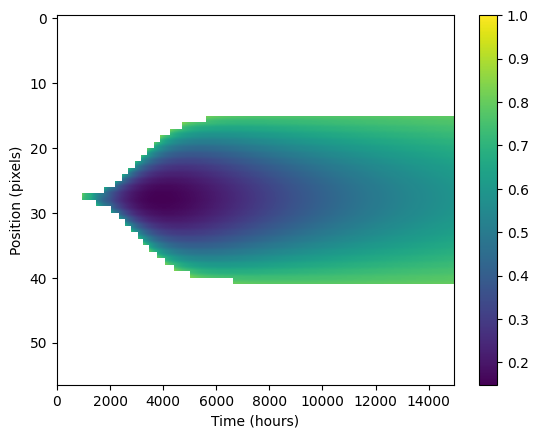

In [42]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[10:,int(nx//2),:].transpose(), [0.025])
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

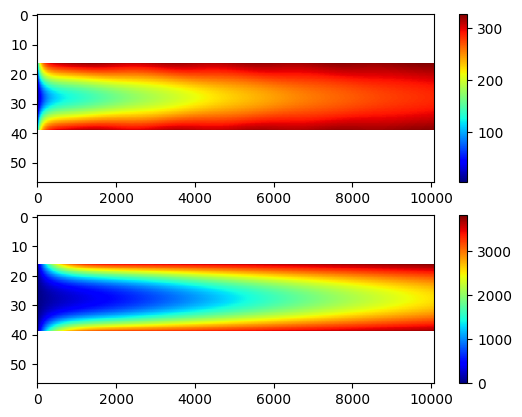

In [43]:
plt.subplot(2,1,1)
plt.imshow(pmask[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(pmask[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

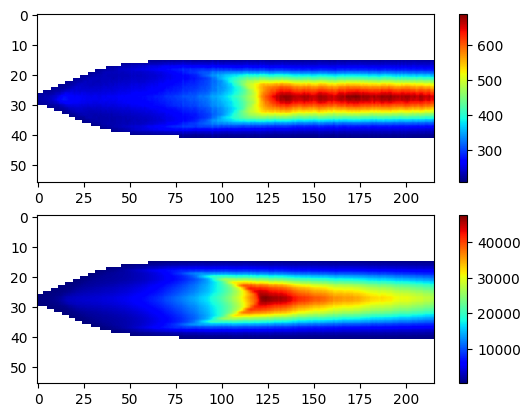

In [218]:
plt.subplot(2,1,1)
plt.imshow(crop_im[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(crop_im[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [14]:
from scipy.signal import savgol_filter

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01

In [46]:
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])

48 216


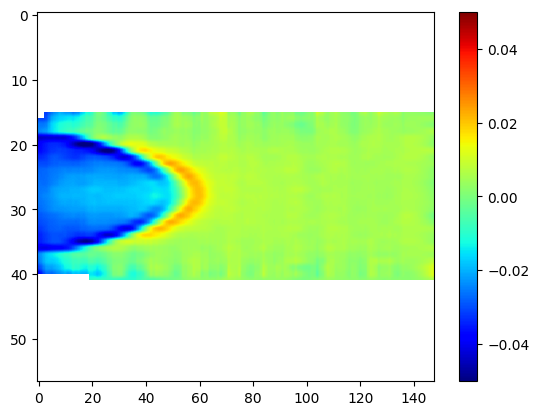

In [47]:
idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)
print(idx0, idx1)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [51]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    kappa, gamma, rep00, rep01, rep02, K0 = np.exp(x)
    ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
    u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
    pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

    p = pmask[60 * 20:-1:60,:,:,:]
    u = u[60 * 20:-1:60,:,:]
    mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
    #denom = (1 + (u / KK2)**nn) * (1 + (u / KK3)**nn)
    #mdslrho = ( (1 + KK2**nn) * (u / KK2)**nn / p[:,:,:,2] / (1 + (p[:,:,:,1]/K)**n) - (1 + KK3**nn) * (u / KK3)**nn / p[:,:,:,3] ) / denom * 60 * 10
    #r2 = (1 + KK2**nn) * (u / KK2)**nn / (1 + (u / KK2)**nn) / p[:,:,:,2] / (1 + (p[:,:,:,1]/K)**n)
    #r3 = (1 + KK3**nn) * (u / KK3)**nn / (1 + (u / KK3)**nn) / p[:,:,:,3]
    #r2 = hill(u, KK2, nn) / hill(1, KK2, nn) / (1 + (p[:,:,:,1]/K)**n) / p[:,:,:,2]
    #r3 = hill(u, KK3, nn) / hill(1, KK3, nn) / p[:,:,:,3]
    #mdslrho = (r2 - r3) * 60 * 10
    idx0 = int(8 * 60 * 60 // dt // 60)
    tidx0 = idx0 + 20
    tidx1 = int(36 * 60 * 60 // dt // 60)
    resid = mdslrho[:,int(nx//2),:] - dslrho[tidx0:tidx1,int(nx//2),:]
    #resid = mdslrho - dslrho[tidx0:tidx1,:,:]
    idx = np.isfinite(np.array(resid))
    resid = resid[idx].ravel()
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [58]:
from scipy.optimize import least_squares, fmin, minimize

rep00,rep01,rep02 = 5,1e-3,1e-3
alpha0,alpha1,alpha2,alpha3 = 1,1,1,1
alpha = 1
beta0,beta1,beta2 = 0,0,0 # 1e-3,1e-3,1e-3
K1,K2,K3 = 1e2,1e2,1e2
K = 1
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 2
nn = 1
#kappa = 1e-14
gamma = 1
gamma_fp = np.log(2) / (12 * 60 * 60)
gamma_repr = np.log(2) / (1 * 60 * 60)
dx = 16e-6
dt = 10
t0 = 0

#ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
#umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
#uu = umask[:-1,:,:]

rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#kappa, rep00, rep01, rep02,K,gamma_repr,KK0,KK1,KK2,KK3,nn = [1.90477568e-13, 2.40914790e-02, 1.23843785e+00, 3.67041049e+03, 2.42493865e+03, 2.92348718e-04, 4.55484789e-01, 3.22305581e-01, 2.66946556e-01, 2.84130169e-01, 6.74474278e+00]
#kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = [1.46369824e-13, 5.41780938e+00, 2.41599534e+02, 1.02036301e+03, 4.45643474e+00, 1.71248412e+03, 3.20572744e-04, 2.29179548e-01, 3.54992148e-02, 4.78930529e-02, 4.24058609e-02, 9.59379329e+00]
#_,kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single.npy')
#alpha0, alpha1, alpha2, alpha3, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg_alpha_no_Ks.npy')
#kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg.npy')
kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')
kappa, gamma, rep00, rep01, rep02, K0 = np.load('xopt_single_iptg_balanced.npy')
K1,K2 = K,K
#lb = [1e-14, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, gamma_repr/10, 1e-6, 1e-6, 1e-6, 1e-6]
#ub = [1e-12, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, gamma_repr*10, 1e6, 1e6, 1e6, 1e6]
lb = [1e-16] + [1e-6] * 5
ub = [1e-12] + [1e6] * 5
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([kappa, gamma, rep00, rep01, rep02, K0]), bounds=bounds, ftol=1e-3)

[2.33511623e-13 1.33472922e+01 1.12596688e+05 4.94426057e+04
 6.59301198e+04 4.88050445e+03]
14940
10080
mse = 4.7806122858688524e-05
[2.33511522e-13 1.33472922e+01 1.12596688e+05 4.94426057e+04
 6.59301198e+04 4.88050445e+03]
14940
10080


KeyboardInterrupt: 

In [33]:
print(res)
print(np.exp(res.x))
print(np.log(2) / gamma_repr / 60)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.225e-03 -9.985e-03 ... -7.700e-03 -1.135e-02]
           x: [-2.904e+01  2.664e+00  1.155e+01  1.054e+01  1.028e+01
                8.511e+00]
        cost: 0.08827212443633381
         jac: [[-9.780e-10 -4.934e-07 ... -7.800e-02 -3.399e-02]
               [ 9.046e-05 -2.342e-04 ... -7.795e-02 -3.403e-02]
               ...
               [ 8.619e-08 -1.576e-07 ... -2.249e-07  4.913e-07]
               [ 1.034e-09 -9.657e-09 ... -2.429e-07  4.752e-07]]
        grad: [ 6.787e-04 -4.200e-04 -2.810e-04  9.167e-05  3.362e-05
                2.025e-04]
  optimality: 0.005292819489305696
 active_mask: [0 0 0 0 0 0]
        nfev: 21
        njev: 16
[2.43672197e-13 1.43568708e+01 1.04008983e+05 3.76313997e+04
 2.90443885e+04 4.97108465e+03]
51.42440236022371


In [57]:
np.save('xopt_single_iptg_balanced.npy', np.exp(res.x))

In [54]:
#alpha0,alpha1,alpha2,alpha3,rep00, rep01, rep02 = np.exp(res.x)
#alpha0, alpha1, alpha2, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(res.x) #np.load('xopt_single_iptg_alpha_no_Ks.npy')
#kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg.npy')
#kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3 = np.exp(res.x)
kappa, gamma, rep00, rep01, rep02, K0 = np.exp(res.x)
ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[60 * 20:-1:60,:,:,:]
mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])

14940
10080
49.52155459797289
(10081, 57, 56, 4)


In [55]:
print(f'K0,K1,K2 = {K0,K1,K2}')
print(f'KK0 = {KK0}')
print(f'KK1 = {KK1}')
print(f'KK2 = {KK2}')
print(f'KK3 = {KK3}')
print(f'nn = {nn}')
print(f'kappa, gamma = {kappa,gamma}')
print(f'rep0 = {rep00, rep01, rep02}')
print(f'Repressor half life = {np.log(2) / gamma_repr / 60} mins')


K0,K1,K2 = (4880.50445166441, 2678.665103943869, 2678.665103943869)
KK0 = 0.13153270028365505
KK1 = 0.0011859132237181818
KK2 = 0.001498556527152728
KK3 = 6.204467190457258e-05
nn = 15.682192315083379
kappa, gamma = (2.335116227258874e-13, 13.347292152183751)
rep0 = (112596.68801262804, 49442.60567870087, 65930.11979327777)
Repressor half life = 51.89111730421959 mins


21252
6 37 28


/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_14082/1821585039.py:11: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(x), y, '.')


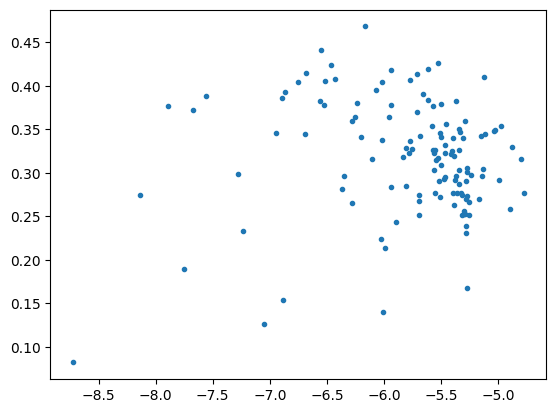

In [65]:
idx = np.nanargmin(corr[idx0+20:idx1,:,:])
print(idx)
it,ix,iy = np.unravel_index(idx, corr.shape)
print(it,ix,iy)

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

x = dslrho[idx0+20:idx1,ix,iy]
y = corr[idx0+20:idx1,ix,iy]
plt.plot(np.log(x), y, '.')

In [91]:
print(K0/KK0)
print(K1/KK1)
print(K2/KK2)
print(nn / 4 * KK0 / K0)
print(nn / 4 * KK1 / K1)
print(nn / 4 * KK2 / K2)

808.9738889525427
10660.958281453655
8768.694619141439
0.015415944787145983
0.0011697913524369116
0.0014222295732721313


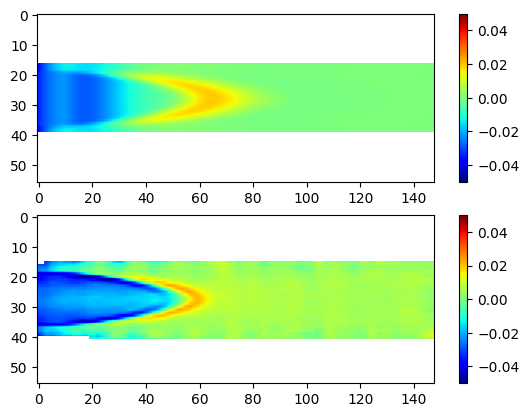

In [56]:
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

plt.subplot(2, 1, 2)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

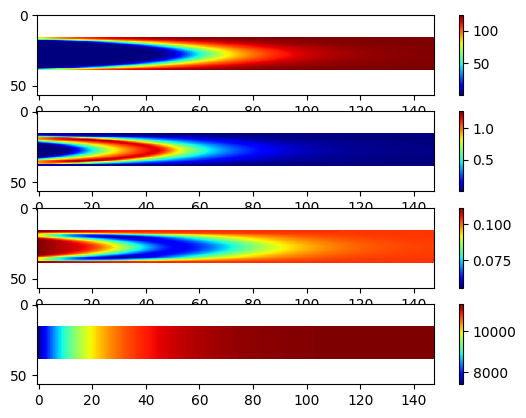

In [149]:
plt.subplot(4, 1, 1)
plt.imshow(p[:,int(nx//2),:,0].transpose() / K0, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(p[:,int(nx//2),:,1].transpose() / K1, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 3)
plt.imshow(p[:,int(nx//2),:,2].transpose() / K2, aspect='auto', cmap='jet')
plt.colorbar()
plt.subplot(4, 1, 4)
plt.imshow(p[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet')
plt.colorbar()

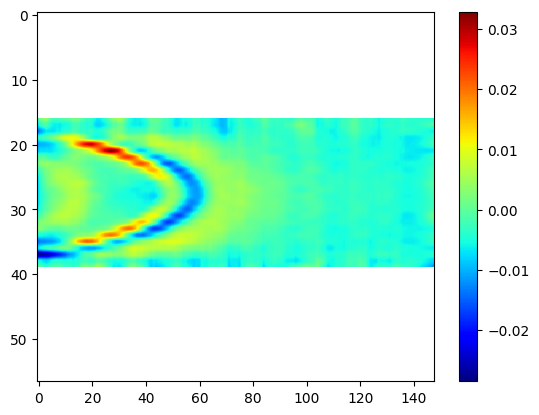

In [150]:
err = mdslrho[:,int(nx//2),:] - dslrho[idx0+20:idx1,int(nx//2),:]
plt.imshow(err.transpose(), aspect='auto', cmap='jet')
plt.colorbar()

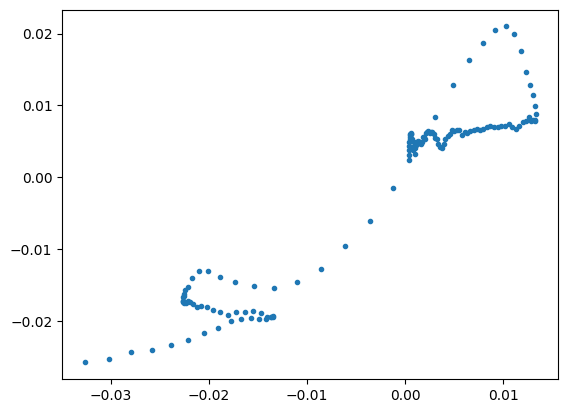

In [151]:
plt.plot(mdslrho[:,int(nx//2),int(ny//2)].ravel(), dslrho[idx0+20:idx1,int(nx//2),int(ny//2)].ravel(), '.')

In [152]:
x,y = mdslrho[:,int(nx//2),int(ny//2)].ravel(), dslrho[idx0+20:idx1,int(nx//2),int(ny//2)].ravel()
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
np.corrcoef(x, y)

array([[1.        , 0.94851982],
       [0.94851982, 1.        ]])

In [296]:
from scipy.signal import correlate, correlation_lags

cc = correlate(x, y)
lags = correlation_lags(len(x), len(y))

0


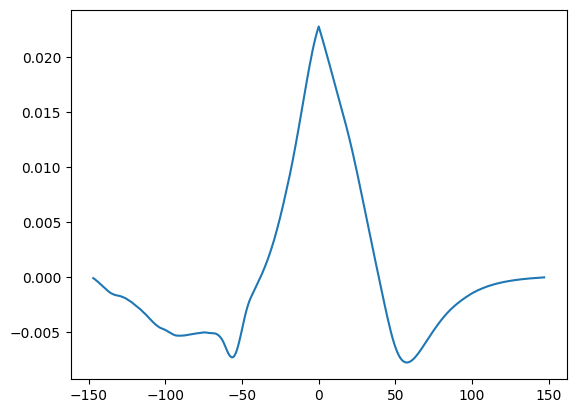

In [297]:
plt.plot(lags, cc)
print(lags[np.argmax(cc)])

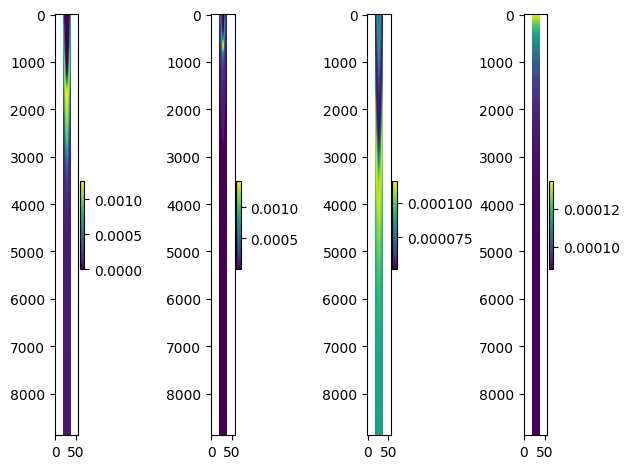

In [153]:
uuu = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
uuu = uuu[60*20:,int(nx//2),:]
x = uuu # [~np.isnan(uuu)].ravel() # np.logspace(-2, 0, 100)
y0 = hill(x, KK0, nn) / hill(1, KK0, nn) / (1 + (pmask[60*20:-1,int(nx//2),:,2]/K2)**n) / pmask[60*20:-1,int(nx//2),:,0]
plt.subplot(1, 4, 1)
plt.imshow(y0, aspect='auto')
plt.colorbar()
y1 = hill(x, KK1, nn) / hill(1, KK1, nn) / (1 + (pmask[60*20:-1,int(nx//2),:,0]/K0)**n) / pmask[60*20:-1,int(nx//2),:,1]
plt.subplot(1, 4, 2)
plt.imshow(y1, aspect='auto')
plt.colorbar()
y2 = hill(x, KK2, nn) / hill(1, KK2, nn) / (1 + (pmask[60*20:-1,int(nx//2),:,1]/K1)**n) / pmask[60*20:-1,int(nx//2),:,2]
plt.subplot(1, 4, 3)
plt.imshow(y2, aspect='auto')
plt.colorbar()
y3 = hill(x, KK3, nn) / hill(1, KK3, nn) / pmask[60*20:-1,int(nx//2),:,3]
plt.subplot(1, 4, 4)
plt.imshow(y3, aspect='auto')
plt.colorbar()

plt.tight_layout()


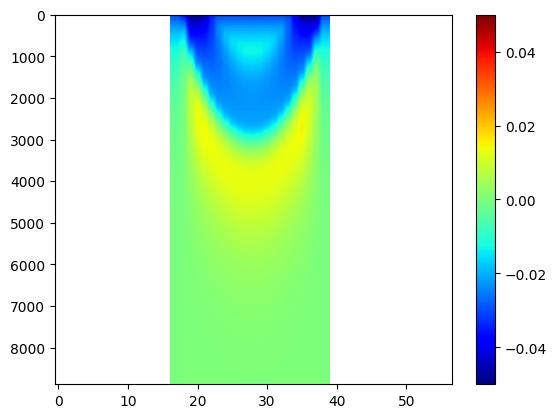

In [154]:
plt.imshow(y2 * 60 * 10 - y3 * 60 * 10, aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05)
plt.colorbar()

/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_3779/3065728504.py:10: RuntimeWarning: invalid value encountered in sqrt
  corr = covw[:,:,0,1] / np.sqrt(covw[:,:,0,0] * covw[:,:,1,1])


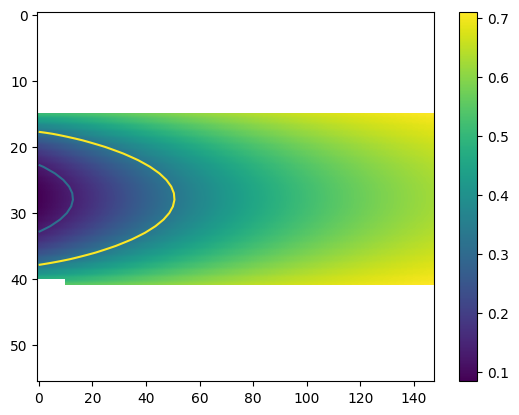

In [59]:
uuu = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
uuu = uuu[20 * 60:-1:60,int(nx//2),:]
x = uuu 

c = cov[idx0+20:idx1,int(nx//2),:,:,:]
dcdt = savgol_filter(c, 31, 3, deriv=1, axis=0)
sc = savgol_filter(c, 31, 3, deriv=0, axis=0)

covw = dcdt + 2 * gamma_repr * sc * 60 * 10
corr = covw[:,:,0,1] / np.sqrt(covw[:,:,0,0] * covw[:,:,1,1])
plt.imshow(x.transpose(), aspect='auto') #, vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()

plt.contour(x.transpose(), np.sort([KK0,KK1,KK2,KK3]))

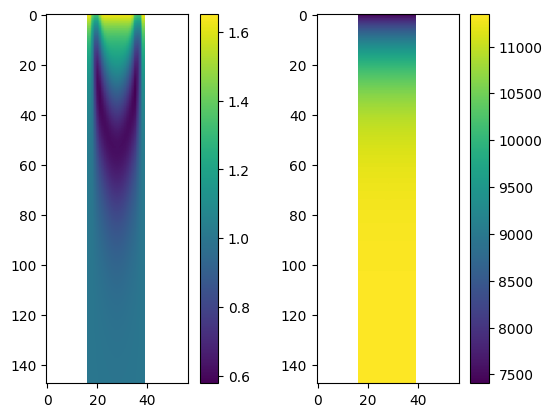

In [155]:
plt.subplot(1,2,1)
plt.imshow(p[:,int(nx//2),:,2] / p[:,int(nx//2),:,3])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(p[:,int(nx//2),:,3])
plt.colorbar()

14940
10080
0.0
(10081, 57, 57, 4)
10080
0.0
(10081, 57, 57, 4)
10080
0.0
(10081, 57, 57, 4)
10080
0.0
(10081, 57, 57, 4)
10080


/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_97229/3160767975.py:6: RuntimeWarning: overflow encountered in power
  xx = (x/K)**n
/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_97229/3160767975.py:7: RuntimeWarning: invalid value encountered in divide
  return xx/(1 + xx) * (1 + K**n)


0.0
(10081, 57, 57, 4)


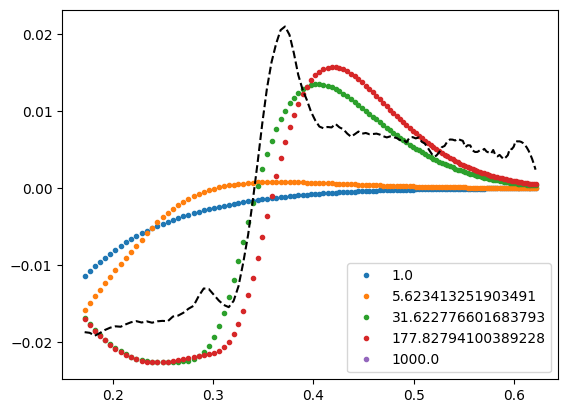

In [160]:
kappa,gamma,rep00, rep01, rep02,K0,K1,K2,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_iptg.npy')
#kappa,gamma,rep00, rep01, rep02,K1,K2,gamma_repr,KK0, KK1, KK2, KK3, nn = np.exp(res.x)
ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
uuu = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
uuu = uuu[60 * 40:-1:60,int(nx//2),int(ny//2)]
x = uuu 

ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
nns = np.logspace(0, 2, 5)
for nn in nns:
    pmask = solve_gene_expression(rep00, rep01, rep02, uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:], 1, 1, 1, 1, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp, ts2)
    print(np.nanmin(pmask))
    print(pmask.shape)
    p = pmask[60 * 40:-1:60,:,:,:]
    mrho,mdslrho = compute_rho(p[:,:,:,2], p[:,:,:,3])  
    plt.plot(x.ravel(), mdslrho[:,int(nx//2),int(ny//2)].ravel(), '.')
plt.legend(nns.astype(str))

rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])
plt.plot(x.ravel(), dslrho[idx0+40:idx1,int(nx//2),int(ny//2)].ravel(), 'k--')